# Семинар 4 - Интерполяция изображений, геометрия формирования изображения и калибровка камеры

***

In [1]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Интерполяция изображений

![](data/interpolation.svg)
Задача - эффективно уменьшить/увеличить изображение.

Рассмотрим несколько методов интерполяции.

## а) Интерполяция по ближайшему пикселю

![](data/inter_nearest.png)

Самая простая и самая быстрая, однако она приводит к сильным артефактам.

## б) Билинейная интерполяция

![](data/inter_linear.png)

Лучше по качеству, но требует больше вычислений и вдобавок размывает границы объектов.

## в) Бикубическая интерполяция

![](data/inter_cubic.png)

Еще лучше в непрерывных областях, но на границе возникает [эффект гало](https://ru.wikipedia.org/wiki/Гало) (более темная полоса вдоль темного края границы и светлая вдоль светлого).

## Примеры

Согласно [документации OpenCV](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является `cv.INTER_AREA`,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: `cv.INTER_CUBIC` (медленный) и `cv.INTER_LINEAR`.

In [2]:
interpolation_algorithm = [
    ("nearest", cv2.INTER_NEAREST),
    ("bilinear", cv2.INTER_LINEAR),
    ("bicubic", cv2.INTER_CUBIC),
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}')

    fig, axes = plt.subplots(
        nrows=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(3, 20)
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized, cmap='Greys_r')
        axes[i].set_title(
            f"{interpolation_algorithm[i][0]}, shape = {img_resized.shape}",
        )

### Оригинальное изображение

Text(0.5, 1.0, 'Original image, shape = (50, 50)')

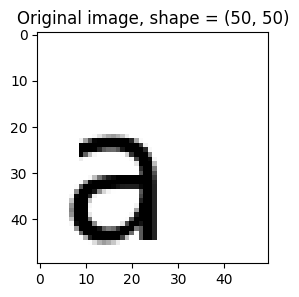

In [3]:
IMG_PATH = "data/a_letter.png"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_04/data .

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(3, 3))
plt.imshow(a_letter_img, cmap="Greys_r")
plt.title(f"Original image, shape = {a_letter_img.shape}")

### Увеличение

orig size: h=50, w=50, resised size: h=250, w=250


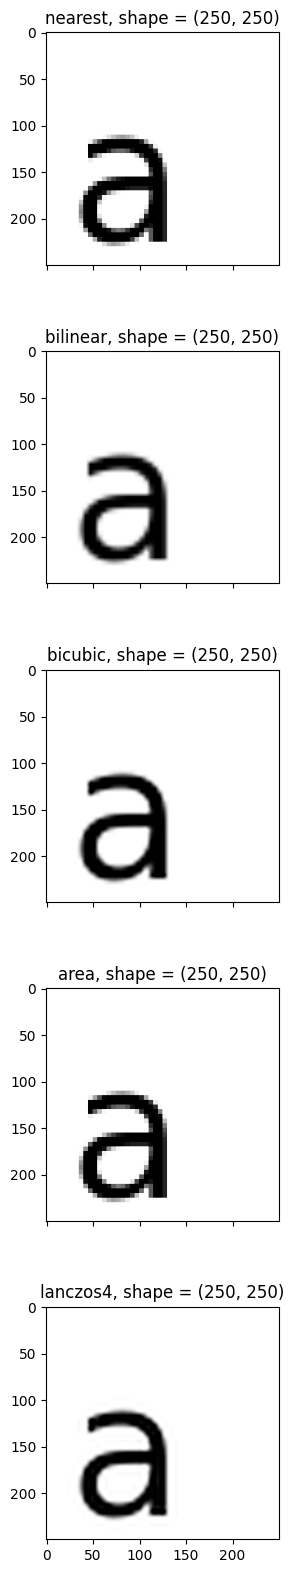

In [4]:
resize_by_factor(
    img=a_letter_img,
    factor=5,
)

### Уменьшение

orig size: h=50, w=50, resised size: h=25, w=25


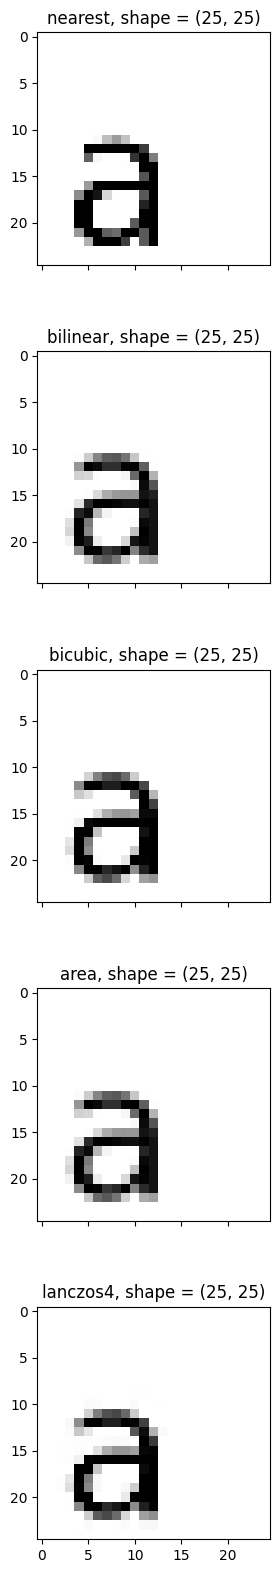

In [5]:
resize_by_factor(
    img=a_letter_img,
    factor=0.5,
)

# Упражение 1

Можно ли реализовать сжатие изображений на свертках? Реализуйте свертку, которая будет уменьшать изображение в 2 раза.

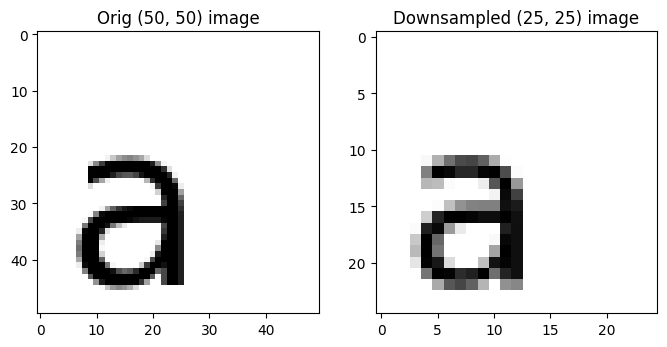

In [6]:
def custom_convolution(image, kernel, stride=1):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = (kernel_height - 1) / 2
    pad_width = (kernel_width - 1) / 2

    padded_image = np.pad(image, ((int(pad_height), int(pad_height)), (int(pad_width), int(pad_width))), mode='constant')

    result_height = (image_height + int(2 * pad_height) - kernel_height) // stride + 1
    result_width = (image_width + int(2 * pad_width) - kernel_width) // stride + 1
    result_image = np.zeros((result_height, result_width))

    for i in range(0, image_height + int(2 * pad_height) - kernel_height + 1, stride):
        for j in range(0, image_width + int(2 * pad_width) - kernel_width + 1, stride):
            conv_sum = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)
            conv_sum = np.clip(conv_sum, 0, 255)
            result_image[i//stride, j//stride] = conv_sum

    return result_image

fig, axes = plt.subplots(1, 2, figsize=(8, 8))

kernel = np.ones((2, 2), np.float32) / 4
downsampled_img = custom_convolution(a_letter_img, kernel, stride=2)

axes[0].imshow(a_letter_img, cmap="gray")
axes[0].set_title(f"Orig {a_letter_img.shape} image")

axes[1].imshow(downsampled_img, cmap="gray")
axes[1].set_title(f"Downsampled {downsampled_img.shape} image")
plt.show()

# Трансформация изображений

[Туториал OpenCV "Geometric Transformations of Images"](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html)

![](data/image_transformations.png)
_Источник - [Computer Vision: Algorithms and Applications, 2nd ed. 2022 Richard Szeliski](https://szeliski.org/Book/)_

## Поворот (Rotation)

Входные параметры: угол поворота (angle)

```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```

## Растяжение/сжатие (Scale)

Входные параметры: фактор растяжения (tx, ty)

```python
matrix = np.array([
      [t[0], 0,    0],
      [0,    t[1], 0],
      [0,    0,    1],
])
```

## Перенос (translation)

Входные параметры: фактор переноса (tx, ty)

```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

## Сдвиг (shearing)

Входные параметры: фактор сдвига (tx, ty)

```python
matrix_horisontal = np.array([
      [1,    t[0], 0],
      [t[1], 1,    0],
      [0,    0,    1],
])
```


# Упражнение 2

Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Не забудьте про центрирование.

Идея - афинное перемещение пикселей изображения.

In [7]:
def affine_transform(
    img: np.array,
    mat: np.array,
) -> np.array:
    H, W = img.shape[:2]

    transformed_img = np.zeros_like(img)
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    out_of_bounds = 0
    for x in range(H):
        for y in range(W):
            pt = np.array([x - cx, y - cy, 1])
            pt_transformed = np.dot(mat, pt)
            x_transformed, y_transformed, _ = pt_transformed
            x_transformed, y_transformed = round(x_transformed + cx), round(y_transformed + cy)

            if 0 <= x_transformed < H and 0 <= y_transformed < W:
                transformed_img[x_transformed, y_transformed] = img[x, y]
            else:
                out_of_bounds += 1

    print(f'Out of bounds pixels: {out_of_bounds}')
    return transformed_img

def make_rotation(
    params,
) -> np.array:

    angle = params[0]

    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)

    mat = np.array([
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])

    return mat

def make_scaling(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [tx, 0, 0],
        [0, ty, 0],
        [0, 0, 1]
    ])

    return mat

def make_translation(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

    return mat

def make_shearing(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [1, tx, 0],
        [ty, 1, 0],
        [0, 0, 1]
    ])

    return mat

Проверьте код на примере изображения c астронавтом

In [8]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    tx=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),

    ty=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
    angle=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
)
def play_with_params(
    tx: float,
    ty: float,
    angle: float
) -> None:

    mat_rotate = make_rotation(
        (angle,),
    )

    mat_scale = make_scaling(
        (tx, ty),
    )

    mat_translation = make_translation(
        (tx, ty),
    )

    mat_shearing = make_shearing(
        (tx, ty),
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for idx, mat in enumerate([mat_rotate, mat_scale, mat_translation, mat_shearing]): 
        transformed_img = affine_transform(
            img=img,
            mat=mat
        )
        axes[idx // 2, idx % 2].imshow(transformed_img)

    plt.show()

interactive(children=(FloatSlider(value=1.0, description='tx', max=3.14, min=-3.14, step=0.01), FloatSlider(va…

# Вопрос 1

Запустите все 4 преобразования. Изменяйте параметры алгоритма. Имеются ли пиксели, которые никуда не перешли в результате трансформации?

**Ответ:**

При разных параметрах все трансформации (кроме переноса) могут имеют артефакты (черные пиксели). В переносе также имеются черные пиксели, но их они не являются артефактами.  
Также есть пиксели, которые вышли за границы изображения и никуда не перешли (их число выводится в виджете)

# Формирование изображения

## Внешние параметры камеры

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

**Радиальные искажения** возникают из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.

**Тангенциальные искажения** возникают из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

Формулы:

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

# Вопрос 2

Запишите выражение связи точек в координатной системе камеры (x, y, z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

**Ответ:**

$$
\begin{pmatrix}
u \\ v \\ w
\end{pmatrix}
=
\begin{pmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z
\end{pmatrix}
\begin{pmatrix}
X \\ Y \\ Z \\ 1
\end{pmatrix}
$$


# Упражнение 3

Найдите параметры вашей камеры мобильного телефона. 

Используйте шаблон шахматной доски. Можете воспользоваться ресурсом https://markhedleyjones.com/projects/calibration-checkerboard-collection  - здесь можно выбрать необходимый размер и подготовить pdf с доской. Во время печати не забудьте проверить, что масштаб не меняется (часто в параметрах печати по умолчанию установлен флаг "scale to fit page").

Воспользуйтесь [туториалом OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

В ответе требуется:

1. Загрузить все сделанные фотографии (туториал рекомендует использовать не менее 10-ти изображений) в папку `./data/calibr_images`. Написанный код должен воспроизводить ваши результаты без дополнительных манипуляций.
2. Вывести найденные параметры калибровки (intrinsic матрицу и параметры дисторсии).
3. Отобразить изображения до и после устранения дисторсии.
4. Посчитать ошибку репроектирования (см. туториал opencv).

In [9]:
import numpy as np
import cv2
import glob


POINTS_PER_ROW = 10
POINTS_PER_COL = 7

CELL_SIZE_IN_MM = 25
THRESHOLD_VALUE = 210

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CELL_SIZE_IN_MM, 0.001)

objp = np.zeros((POINTS_PER_COL * POINTS_PER_ROW, 3), np.float32)
objp[:,:2] = np.mgrid[0:POINTS_PER_ROW,0:POINTS_PER_COL].T.reshape(-1,2)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('data/calibr_images/*.jpeg')
for fname in images:
    img = cv2.imread(fname)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Fix gray squares instead of black (printer problem)
    _, gray = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
    
    
    ret, corners = cv2.findChessboardCorners(gray, (POINTS_PER_ROW, POINTS_PER_COL), None)
    
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    
        cv2.drawChessboardCorners(img, (POINTS_PER_ROW, POINTS_PER_COL), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(1000)
    
    print(f'Image: {fname}, board founded: {ret}')
cv2.destroyAllWindows()

Image: data/calibr_images/IMG_7676.jpeg, board founded: True
Image: data/calibr_images/IMG_7677.jpeg, board founded: True
Image: data/calibr_images/IMG_7666.jpeg, board founded: True
Image: data/calibr_images/IMG_7670.jpeg, board founded: True
Image: data/calibr_images/IMG_7671.jpeg, board founded: True
Image: data/calibr_images/IMG_7667.jpeg, board founded: True
Image: data/calibr_images/IMG_7668.jpeg, board founded: True
Image: data/calibr_images/IMG_7672.jpeg, board founded: True
Image: data/calibr_images/IMG_7665.jpeg, board founded: True
Image: data/calibr_images/IMG_7673.jpeg, board founded: True
Image: data/calibr_images/IMG_7669.jpeg, board founded: True
Image: data/calibr_images/IMG_7674.jpeg, board founded: True
Image: data/calibr_images/IMG_7678.jpeg, board founded: True
Image: data/calibr_images/IMG_7679.jpeg, board founded: True
Image: data/calibr_images/IMG_7675.jpeg, board founded: True


## Calibration

In [11]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [12]:
print(mtx)

[[955.01049201   0.         481.33731294]
 [  0.         957.63474247 639.97102759]
 [  0.           0.           1.        ]]


In [13]:
print(dist)

[[ 2.31676668e-01 -1.42441970e+00 -7.36430706e-06  4.39718816e-04
   2.84304838e+00]]


## Undistortion

In [15]:
img_raw = cv2.imread('data/calibr_images/IMG_7665.jpeg')
_, img_fixed = cv2.threshold(img_raw, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [16]:

img_fixed = cv2.undistort(img_fixed, mtx, dist, None, newcameramtx)

x, y, w, h = roi
img_fixed = img_fixed[y:y+h, x:x+w]
cv2.imwrite('calibresult.png', img_fixed)

True

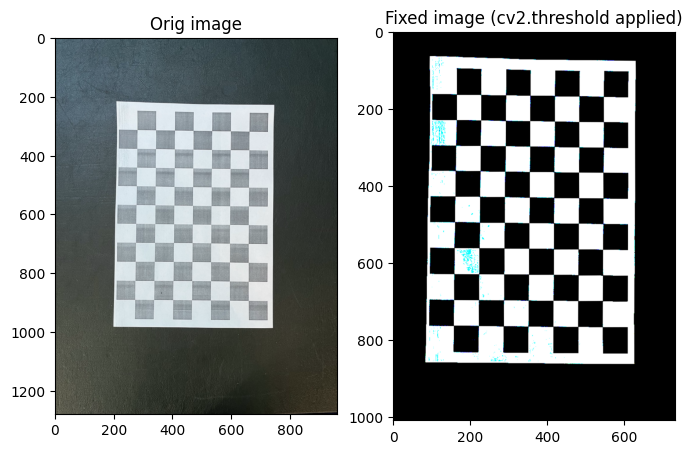

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

axes[0].imshow(img_raw, cmap="gray")
axes[0].set_title(f"Orig image")

axes[1].imshow(img_fixed, cmap="gray")
axes[1].set_title(f"Fixed image (cv2.threshold applied)")
plt.show()

In [18]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.07099198433545961
